In [4]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Audio
from keras.layers import Conv2D, Conv2DTranspose, Input, MaxPooling2D, Add,\
                         BatchNormalization, LeakyReLU, Reshape, Flatten, Dense
from keras.optimizer_v1 import Adam
from keras.models import Model
import tensorflow as tf

from splitter import Splitter
from dataset_preprocessor import PolarSpectrogramExtractor, AudioDatasetFromCSV

tf.compat.v1.disable_eager_execution()

# Load Dataset

In [3]:
extractor = PolarSpectrogramExtractor(1024, 256)

dataset_params = {
    'spectrogram_extractor': extractor,
    'metadata_csv': './dataset_metadata.csv',
    'validation_size': .1,
    'sr': 22050,
    'prepared': True
}

data = AudioDatasetFromCSV(**dataset_params)
data.prepare_dataset()
data.train_test_split()


                Dataset has already been prepared. To load spectrograms,
                call the load_data() method. To rerun the prepare_dataset()
                method, you must first set the 'prepared' attribute to be 
                False.
                
Length of Training Data: 2377
Length of Testing Data: 265


# Skip Connection Autoencoder
This autoencoder contains skip functions that help the network to retain features extracted early in the network for use later in the network what the decoder is reconstructed a denoised signal. This greatly increases performance and clarity of the audio generated.
[Source for Model Architecture](https://towardsdatascience.com/using-skip-connections-to-enhance-denoising-autoencoder-algorithms-849e049c0ac9)

In [93]:
# Encoder
input_spectrogram = Input(shape=(512, 256, 1))

# Convolution Blocks (2 skip connections)
y = Conv2D(32, (3, 3), padding='same',strides =(2,2), name="conv_1")(input_spectrogram)
y = LeakyReLU()(y)

y = Conv2D(64, (3, 3), padding='same',strides =(2,2), name="conv_2")(y)
y = LeakyReLU()(y)

y2 = Conv2D(128, (3, 3), padding='same',strides =(2,2), name="conv_3_skip")(y)
y = LeakyReLU()(y2)

y = Conv2D(256, (3, 3), padding='same',strides =(2,2), name="conv_4")(y)
y = LeakyReLU()(y)

y1 = Conv2D(256, (3, 3), padding='same',strides =(2,2), name="conv_5_skip")(y)
y = LeakyReLU()(y1)

y = Conv2D(512, (3, 3), padding='same',strides =(2,2), name="conv_6")(y)
y = LeakyReLU()(y)

y = Conv2D(1024, (3, 3), padding='same',strides =(2,2), name="conv_7")(y)
y = LeakyReLU()(y)

dims = y.shape # shape before bottleneck
x = Flatten()(y)

#latent dims
latent = Dense(256,activation='relu', name="latent")(x) 

In [94]:
# helper function 
def lrelu_bn(inputs):
    lrelu = LeakyReLU()(inputs)
    bn = BatchNormalization()(lrelu)
    return bn   

In [95]:
# Decoder
y = Dense(np.prod(dims[1:]), activation='relu')(latent) #latent input
y = Reshape((dims[1], dims[2], dims[3]))(y) # recover shape before bottleneck

# Conv Transpose Blocks Mirror Encoder (2 skip)
y = Conv2DTranspose(1024, (3,3), padding='same', name="convt_7")(y)
y = LeakyReLU()(y)

y = Conv2DTranspose(512, (3,3), padding='same',strides=(2,2), name="convt_6")(y)
y = LeakyReLU()(y)

y = Conv2DTranspose(256, (3,3), padding='same',strides=(2,2), name="convt_5_skip")(y)
y= Add()([y1, y]) # skip 2
y = lrelu_bn(y)  

y = Conv2DTranspose(256, (3,3), padding='same',strides=(2,2), name="convt_4")(y)
y = LeakyReLU()(y) 

y = Conv2DTranspose(128, (3,3), padding='same',strides=(2,2), name="convt_3_skip")(y)   
y= Add()([y2, y]) # skip 1
y = lrelu_bn(y) 

y = Conv2DTranspose(64, (3,3), padding='same',strides=(2,2), name="convt_2")(y)
y = LeakyReLU()(y)

y = Conv2DTranspose(32, (3,3), padding='same',strides=(2,2), name="convt_1")(y)
y = LeakyReLU()(y)

# Output
y = Conv2DTranspose(1, (3,3), activation='sigmoid', padding='same',strides=(2,2))(y)

In [96]:
ae = Model(input_spectrogram, y, name="skip_ae")

In [97]:
ae.compile(loss='mse', optimizer=Adam(lr=0.0001))
ae_history = ae.fit(
    data.x_train_rho, 
    data.y_train_rho,      
    validation_data=(data.x_test_rho, data.y_test_rho),
    epochs=125, 
    batch_size=32
)

Train on 2377 samples, validate on 265 samples
Epoch 1/125


2023-06-12 07:26:35.777856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-12 07:26:35.894977: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-12 07:26:36.324470: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2377/2377 [==============================] - ETA: 0s - loss: 0.0306

/Users/jacksonnelson/miniconda3/envs/tf_metal/lib/python3.8/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-06-12 07:27:38.793061: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2377/2377 [==============================] - 66s 28ms/sample - loss: 0.0306 - val_loss: 0.0439
Epoch 2/125
2377/2377 [==============================] - 49s 21ms/sample - loss: 0.0077 - val_loss: 0.0278
Epoch 3/125
2377/2377 [==============================] - 48s 20ms/sample - loss: 0.0046 - val_loss: 0.0132
Epoch 4/125
2377/2377 [==============================] - 48s 20ms/sample - loss: 0.0041 - val_loss: 0.0080
Epoch 5/125
2377/2377 [==============================] - 47s 20ms/sample - loss: 0.0037 - val_loss: 0.0043
Epoch 6/125
2377/2377 [==============================] - 47s 20ms/sample - loss: 0.0031 - val_loss: 0.0038
Epoch 7/125
2377/2377 [==============================] - 48s 20ms/sample - loss: 0.0029 - val_loss: 0.0034
Epoch 8/125
2377/2377 [==============================] - 48s 20ms/sample - loss: 0.0028 - val_loss: 0.0038
Epoch 9/125
2377/2377 [==============================] - 50s 21ms/sample - loss: 0.0026 - val_loss: 0.0027
Epoch 10/125
2377/2377 [=========================

In [98]:
pd.DataFrame(ae_history.history).to_csv("./256_ae_skip_history_125.csv")

In [69]:
ae.save_weights("./256_as_dkip_weights_125.h5")

In [70]:
rho_preds = ae.predict(data.x_test_rho)

/Users/jacksonnelson/miniconda3/envs/tf_metal/lib/python3.8/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-06-12 06:38:53.034416: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


# Get Full Training History

In [99]:
df = pd.read_csv("./256_ae_skip_history_125.csv")

# Plot Training History

In [100]:
def plot_training(history, title):
    plt.figure(figsize=(12, 8))
    plt.plot(history['loss'], label="Train")
    plt.plot(history['val_loss'], label="Test")
    plt.legend(fontsize=15)
    plt.xlabel("Epoch", size=15)
    plt.ylabel("Mean Squared Error", size=15)
    plt.title(title, size=25)

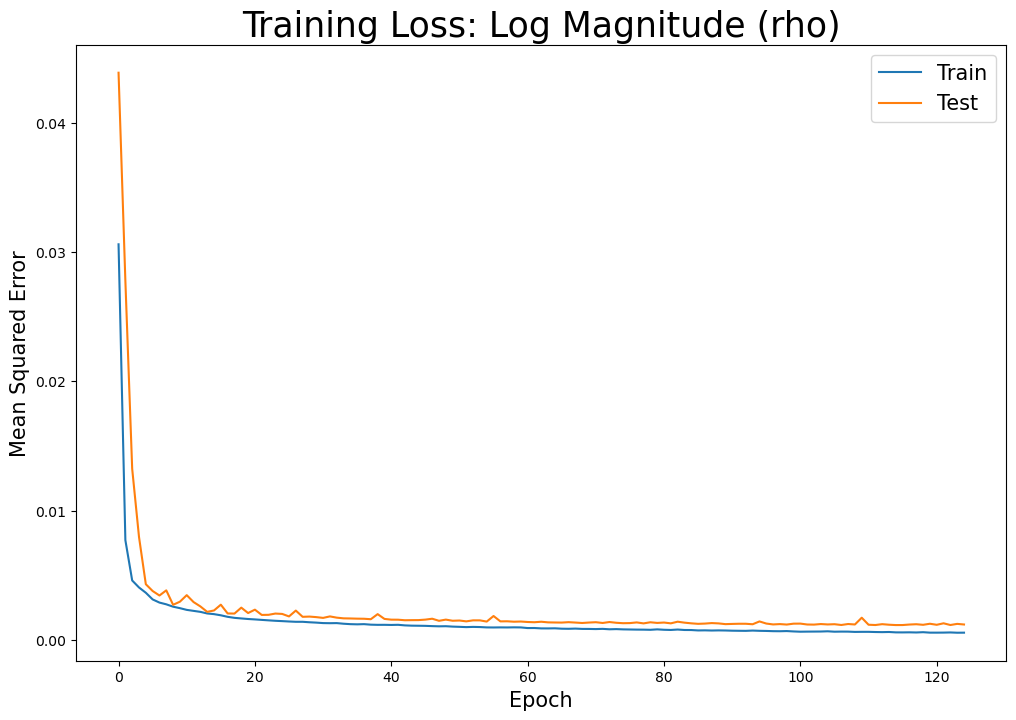

In [101]:
plot_training(df, "Training Loss: Log Magnitude (rho)")

# Get Predictions

In [177]:
def pred_vs_target_audio(extractor, x_preds, dataset, idx=None):
    
    if not idx:
        idx = np.random.randint(low=0, high=len(x_preds))
    
    rho = x_preds[idx]
    theta = dataset.x_test_theta[idx]
    spec = np.concatenate([rho, theta], axis=-1)
    y_true = dataset.y_test[idx]
    noisy = data.x_test[idx]
    
    noisy_signal = extractor.recover_signal(noisy)
    pred_signal = extractor.recover_signal(spec)
    orig_signal = extractor.recover_signal(y_true)
    
    print(f"Sample number {idx}")
    
    print("Noisy Audio")
    display(Audio(data=noisy_signal, rate=22050))
    print("Regenerated Audio")
    display(Audio(data=pred_signal, rate=22050))
    print("Clean Audio")
    display(Audio(data=orig_signal, rate=22050))

In [116]:
x_preds = ae.predict(data.x_test_rho)

/Users/jacksonnelson/miniconda3/envs/tf_metal/lib/python3.8/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-06-12 09:23:15.117990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [172]:
def pred_vs_target(extractor, x_preds, dataset, idx=None):
    
    if not idx:
        idx = np.random.randint(low=0, high=len(x_preds))
    
    rho = x_preds[idx]
    theta = dataset.x_test_theta[idx]
    spec = np.concatenate([rho, theta], axis=-1)
    y_true = dataset.y_test[idx]
    noisy = data.x_test[idx]
    
    noisy_signal = extractor.recover_signal(noisy)
    pred_signal = extractor.recover_signal(spec)
    orig_signal = extractor.recover_signal(y_true)
    
    print(f"Sample number {idx}")
    
    print("Noisy Audio")
    display(Audio(data=noisy_signal, rate=22050))
    display(plt.imshow(data.x_test_rho[idx],origin="lower"))
    plt.axis('off');
    plt.show()
    print("Regenerated Audio")
    display(Audio(data=pred_signal, rate=22050))
    display(plt.imshow(rho[...,0],origin="lower"))
    plt.axis('off');
    plt.show()
    print("Clean Audio")
    display(Audio(data=orig_signal, rate=22050))
    display(plt.imshow(data.y_test_rho[idx],origin="lower"))
    plt.axis('off');
    plt.show()

Sample number 146
Noisy Audio


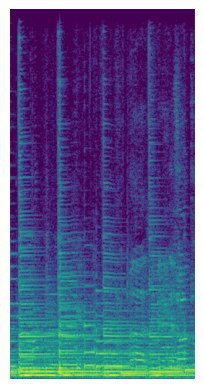

Regenerated Audio


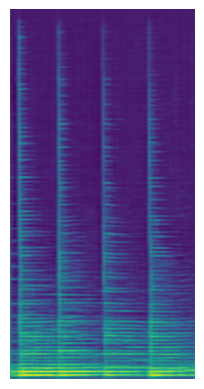

Clean Audio


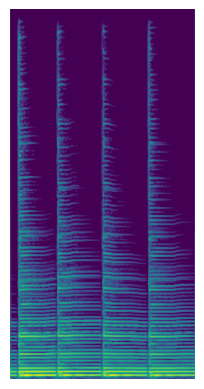

In [173]:
pred_vs_target(extractor, x_preds, data, 146)

Sample number 26
Noisy Audio


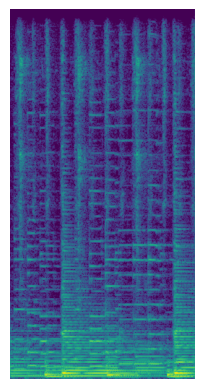

Regenerated Audio


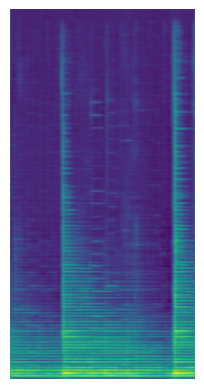

Clean Audio


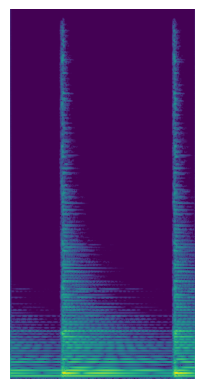

In [174]:
pred_vs_target(extractor, x_preds, data, 26)

Sample number 44
Noisy Audio


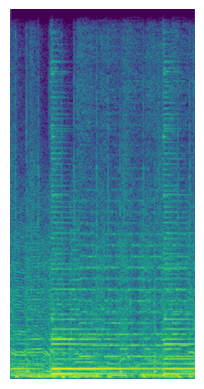

Regenerated Audio


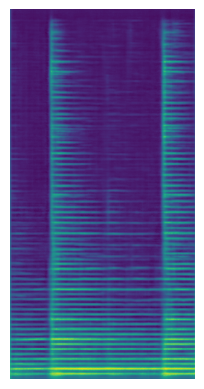

Clean Audio


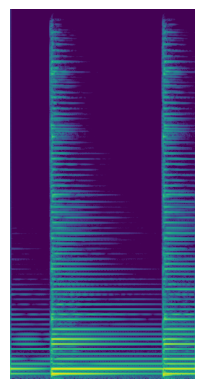

In [175]:
pred_vs_target(extractor, x_preds, data, 44)

Sample number 205
Noisy Audio


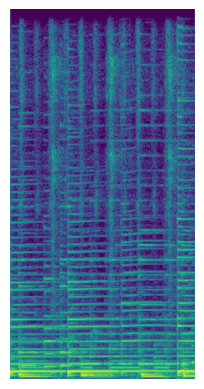

Regenerated Audio


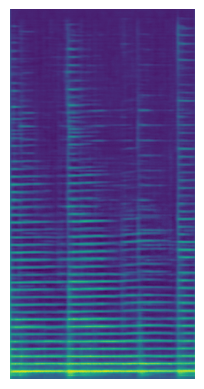

Clean Audio


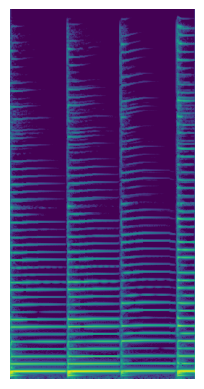

In [176]:
pred_vs_target(extractor, x_preds, data, 205)

In [178]:
pred_vs_target_audio(extractor, x_preds, data, 26)

Sample number 26
Noisy Audio


Regenerated Audio


Clean Audio


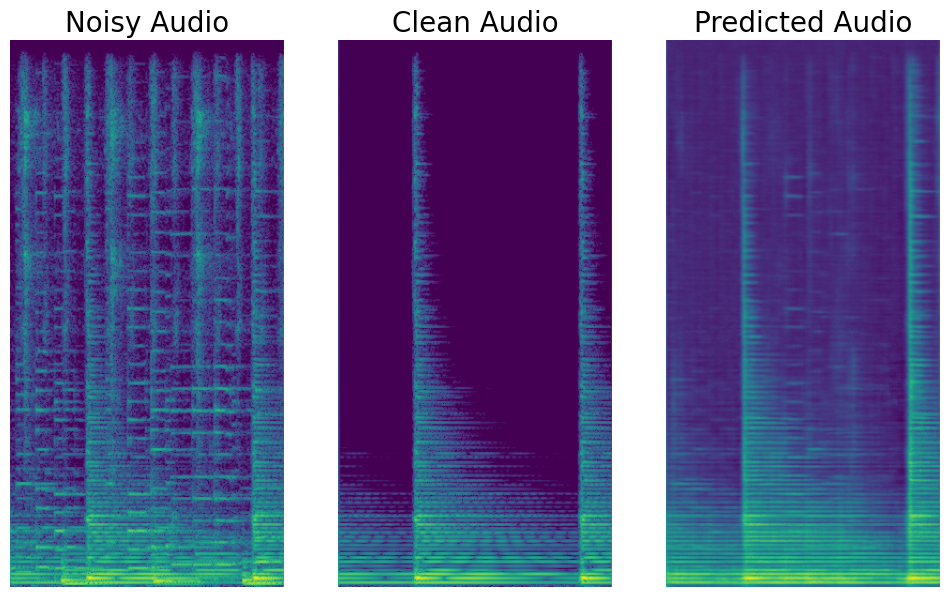

In [180]:
fig, axs = plt.subplots(1, 3, figsize=(12, 8))
axs[0].imshow(data.x_test_rho[26], origin="lower")
axs[1].imshow(data.y_test_rho[26], origin="lower")
axs[2].imshow(x_preds[26][...,0], origin="lower")
axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')
axs[0].set_title('Noisy Audio', size=20)
axs[1].set_title('Clean Audio', size=20)
axs[2].set_title('Predicted Audio', size=20)
plt.savefig("./images/ae_preidcted_spec.png");

In [125]:
pred_vs_target(extractor, x_preds, data, 205)

Sample number 205
Noisy Audio


Regenerated Audio


Clean Audio


# Visualizing Spectrograms

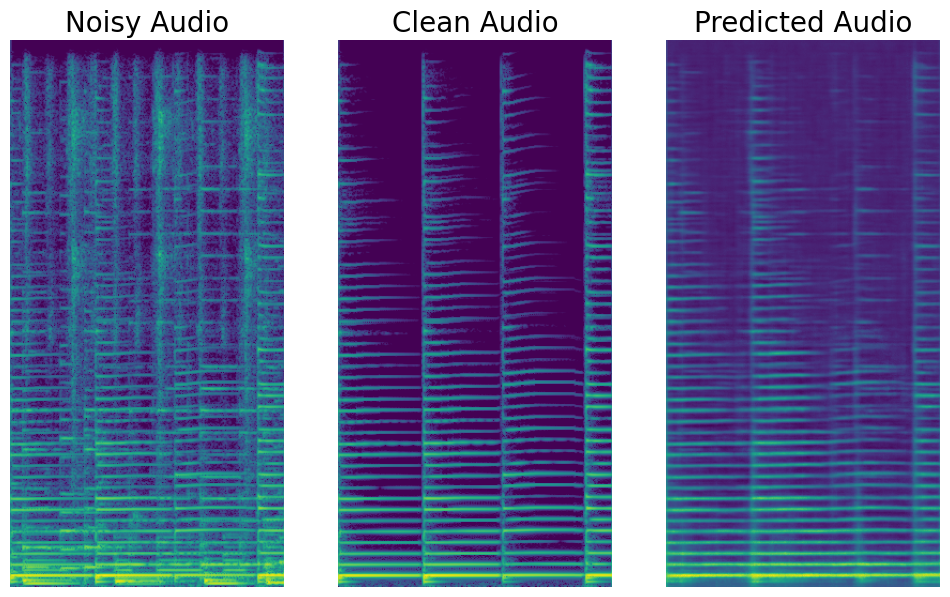

In [124]:
fig, axs = plt.subplots(1, 3, figsize=(12, 8))
axs[0].imshow(data.x_test_rho[205], origin="lower")
axs[1].imshow(data.y_test_rho[205], origin="lower")
axs[2].imshow(x_preds[205][...,0], origin="lower")
axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')
axs[0].set_title('Noisy Audio', size=20)
axs[1].set_title('Clean Audio', size=20)
axs[2].set_title('Predicted Audio', size=20)
plt.savefig("./images/vae_preidcted_spec.png");

# Get Latent Representations

In [104]:
encoder = tf.keras.models.Sequential(
    ae.layers[:17]
)

In [105]:
encoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 256, 128, 32)      320       
                                                                 
 leaky_re_lu_43 (LeakyReLU)  (None, 256, 128, 32)      0         
                                                                 
 conv_2 (Conv2D)             (None, 128, 64, 64)       18496     
                                                                 
 leaky_re_lu_44 (LeakyReLU)  (None, 128, 64, 64)       0         
                                                                 
 conv_3_skip (Conv2D)        (None, 64, 32, 128)       73856     
                                                                 
 leaky_re_lu_45 (LeakyReLU)  (None, 64, 32, 128)       0         
                                                                 
 conv_4 (Conv2D)             (None, 32, 16, 256)      

In [106]:
latent_representations = encoder.predict(data.x_test_rho)

/Users/jacksonnelson/miniconda3/envs/tf_metal/lib/python3.8/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-06-12 09:10:22.972248: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [107]:
avg_latent = latent_representations.mean(axis=0)

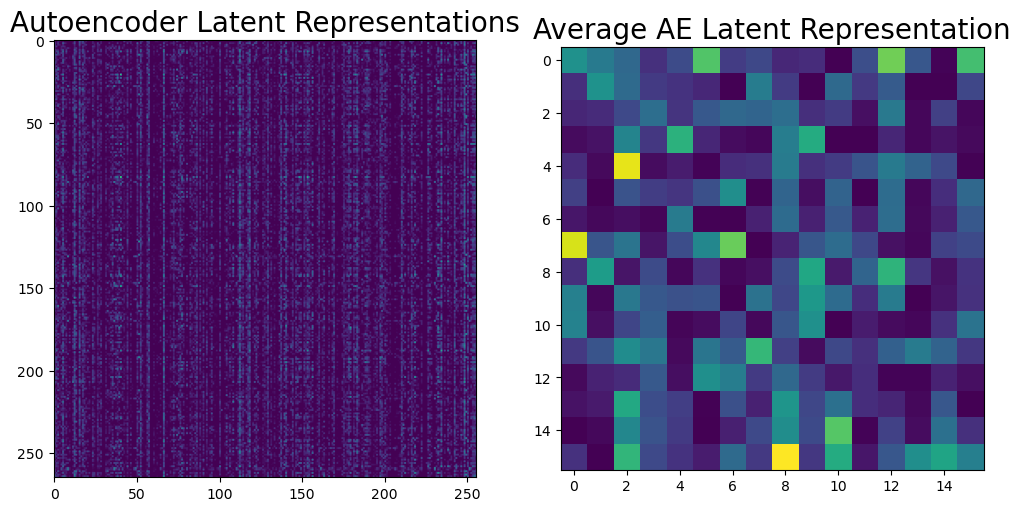

In [114]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].set_title("Autoencoder Latent Representations", size=20)
axs[0].imshow(latent_representations)
axs[1].imshow(avg_latent.reshape(16, 16))
axs[1].set_title("Average AE Latent Representation", size=20)
plt.tight_layout
plt.savefig("./images/ae_latent_average.png");

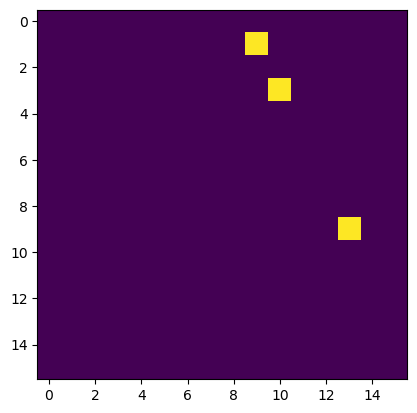

In [113]:
plt.imshow(np.where(avg_latent.reshape(16, 16)==0, 1, 0));

**only 3 of 256 latent dimensions were unused**

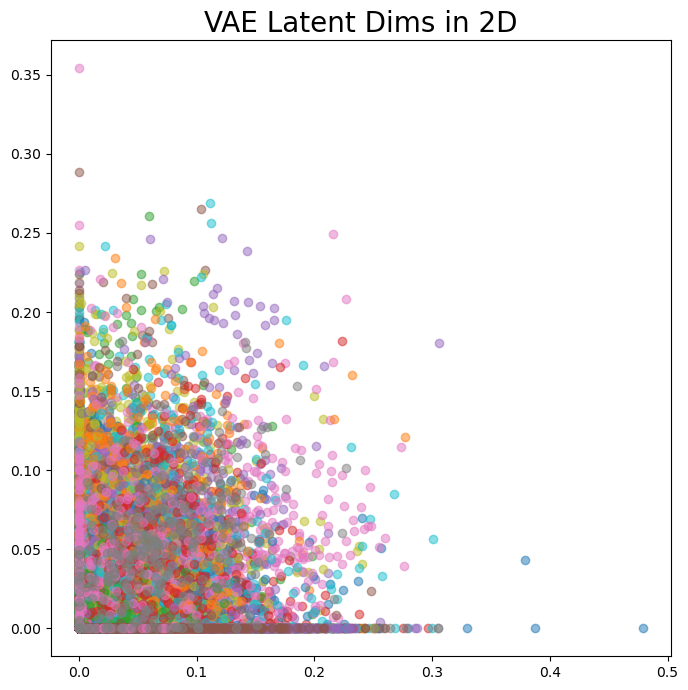

In [131]:
latent_trans = latent_representations.T
plt.figure(figsize=(8, 8))
plt.title("VAE Latent Dims in 2D", size=20)
for i in range(0, len(latent_trans), 2):
    plt.scatter(latent_trans[i], latent_trans[i+1], alpha=0.5)
plt.savefig("./images/ae_latent_scatter.png");

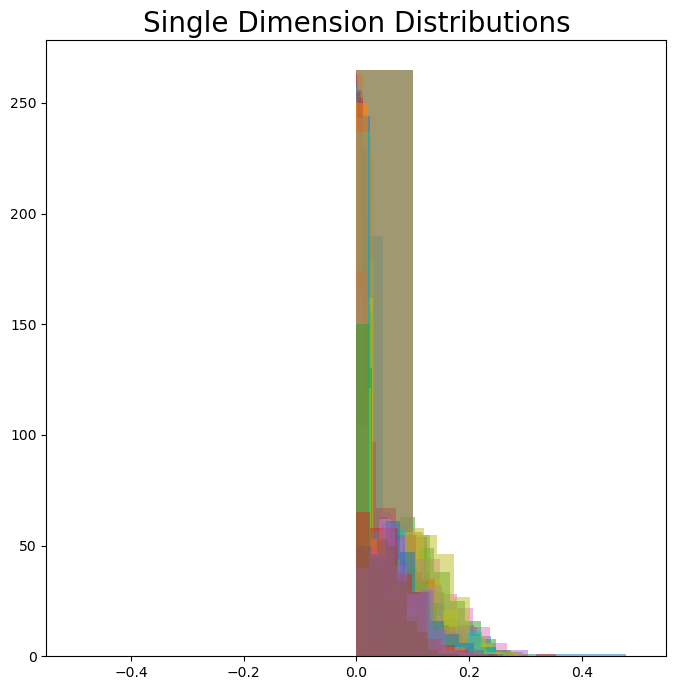

In [130]:
latent_trans = latent_representations.T
plt.figure(figsize=(8, 8))
plt.title("Single Dimension Distributions", size=20)
for i in range(len(latent_trans)):
    plt.hist(latent_trans[i], alpha=0.5)
plt.savefig("./images/ae_latent_dist_hist.png");

# Masking Phase (Theta)

In [ ]:
pred_vs_target(extractor, x_preds, data, 111)

# Train Theta-Decoder on Latent Outputs

## Clone Autoencoder

In [84]:
theta_predictor = tf.keras.models.clone_model(ae)

## Freeze Encoder Weights

In [155]:
for layer in range(17):
    theta_predictor.layers[layer].trainable=False

In [156]:
theta_predictor.summary()

Model: "skip_autoencoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None, 512, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv_1 (Conv2D)                (None, 256, 128, 32  320         ['input_24[0][0]']               
                                )                                                                 
                                                                                                  
 leaky_re_lu_201 (LeakyReLU)    (None, 256, 128, 32  0           ['conv_1[0][0]']                 
                                )                                                  

In [157]:
theta_predictor.compile(loss='mse', optimizer=Adam(lr=0.0001))

## Theta Masking

In [160]:
x_train_pred = autoencoder.predict(data.x_train_rho)
x_test_pred = autoencoder.predict(data.x_test_rho)

In [168]:
x_train_mask = np.array([np.where(rho < rho.mean(), 0, 1) for rho in x_train_pred])
x_test_mask = np.array([np.where(rho < rho.mean(), 0, 1) for rho in x_test_pred])

In [172]:
theta_y_train = np.array([theta * mask for theta, mask in zip(data.y_train_theta, x_train_mask)])
theta_y_test = np.array([theta * mask for theta, mask in zip(data.y_test_theta, x_test_mask)])

In [173]:
theta_results = theta_predictor.fit(
    data.x_train_rho,
    theta_y_train,
    validation_data=(data.x_test_rho, theta_y_test),
    epochs=75,
    batch_size=32
)

Train on 2377 samples, validate on 265 samples
Epoch 1/75


2023-06-11 23:28:22.982596: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-11 23:28:23.316017: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-11 23:28:23.651621: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2377/2377 [==============================] - ETA: 0s - loss: 0.0805

/Users/jacksonnelson/miniconda3/envs/tf_metal/lib/python3.8/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-06-11 23:29:09.828916: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2377/2377 [==============================] - 51s 21ms/sample - loss: 0.0805 - val_loss: 0.1027
Epoch 2/75
2377/2377 [==============================] - 32s 13ms/sample - loss: 0.0623 - val_loss: 0.0972
Epoch 3/75
2377/2377 [==============================] - 32s 13ms/sample - loss: 0.0565 - val_loss: 0.0935
Epoch 4/75
2377/2377 [==============================] - 31s 13ms/sample - loss: 0.0533 - val_loss: 0.0899
Epoch 5/75
2377/2377 [==============================] - 31s 13ms/sample - loss: 0.0519 - val_loss: 0.0850
Epoch 6/75
2377/2377 [==============================] - 32s 14ms/sample - loss: 0.0511 - val_loss: 0.0793
Epoch 7/75
2377/2377 [==============================] - 32s 14ms/sample - loss: 0.0505 - val_loss: 0.0713
Epoch 8/75
2377/2377 [==============================] - 32s 13ms/sample - loss: 0.0499 - val_loss: 0.0627
Epoch 9/75
2377/2377 [==============================] - 31s 13ms/sample - loss: 0.0495 - val_loss: 0.0556
Epoch 10/75
2377/2377 [==============================] - 

In [174]:
pd.DataFrame(theta_results.history).to_csv("theta_results.csv")

In [182]:
theta_predictor.save_weights("./256_theta_training.h5")

# Get Phase Predictions

In [183]:
theta_preds = theta_predictor.predict(data.x_test_rho)

In [179]:
specs = np.concatenate([x_test_pred, theta_preds], axis=-1)
specs.shape

(265, 512, 256, 2)

In [180]:
signal = extractor.recover_signal(specs[0])

# Example
the example below with predicted phase is not much better than just initializing random phase.

In [181]:
Audio(data=signal, rate=22050)

# Full Autoencoder to Predict Theta Spectrogram
With such a poor performance predicted the phase from the latent representations alone, it will definitely be necessary to use the noisy phase as the input to its own encoder-decoder network.

In [85]:
theta_autoencoder = tf.keras.models.clone_model(autoencoder)

In [86]:
for layer in theta_autoencoder.layers:
    layer.trainable = True

In [15]:
x_train_pred = autoencoder.predict(data.x_train_rho)
x_test_pred = autoencoder.predict(data.x_test_rho)


/Users/jacksonnelson/miniconda3/envs/tf_metal/lib/python3.8/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-06-12 00:25:44.349868: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [16]:
x_train_mask = np.array([np.where(rho < rho.mean(), 0, 1) for rho in x_train_pred])
y_train_mask = np.array([np.where(rho < rho.mean(), 0, 1) for rho in data.y_train_theta])
x_test_mask = np.array([np.where(rho < rho.mean(), 0, 1) for rho in x_test_pred])
y_test_mask = np.array([np.where(rho < rho.mean(), 0, 1) for rho in data.y_test_theta])

In [18]:
# X_train
x_train_1 = np.array([theta * mask for theta, mask in zip(data.x_train_theta, x_train_mask)])
x_train_2 = np.array([theta * mask for theta, mask in zip(data.x_train_theta, y_train_mask)])
theta_x_train = np.concatenate([x_train_1, x_train_2], axis=0)

# Y_train
y_train_1 = np.array([theta * mask for theta, mask in zip(data.y_train_theta, x_train_mask)])
y_train_2 = np.array([theta * mask for theta, mask in zip(data.y_train_theta, y_train_mask)])
theta_y_train = np.concatenate([y_train_1, y_train_2], axis=0)

# X_test
x_test_1 = np.array([theta * mask for theta, mask in zip(data.x_test_theta, x_test_mask)])
x_test_2 = np.array([theta * mask for theta, mask in zip(data.x_test_theta, y_test_mask)])
theta_x_test = np.concatenate([x_test_1, x_test_2], axis=0)

# Y_test
y_test_1 = np.array([theta * mask for theta, mask in zip(data.y_test_theta, x_test_mask)])
y_test_2 = np.array([theta * mask for theta, mask in zip(data.y_test_theta, y_test_mask)])
theta_y_test = np.concatenate([y_test_1, y_test_2], axis=0)

In [19]:
theta_autoencoder.compile(loss="mse", optimizer=Adam(lr=0.00001))

In [21]:
theta_ae_results = theta_autoencoder.fit(
    theta_x_train, 
    theta_y_train,
    validation_data=(theta_x_test, theta_y_test),
    epochs=75,
    batch_size=32
)

Train on 4754 samples, validate on 530 samples
Epoch 1/75
4754/4754 [==============================] - ETA: 0s - loss: 0.1051

/Users/jacksonnelson/miniconda3/envs/tf_metal/lib/python3.8/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-06-12 00:34:00.635162: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4754/4754 [==============================] - 112s 23ms/sample - loss: 0.1051 - val_loss: 0.1409
Epoch 2/75
4754/4754 [==============================] - 96s 20ms/sample - loss: 0.0715 - val_loss: 0.1111
Epoch 3/75
4754/4754 [==============================] - 94s 20ms/sample - loss: 0.0575 - val_loss: 0.0725
Epoch 4/75
4754/4754 [==============================] - 93s 19ms/sample - loss: 0.0496 - val_loss: 0.0506
Epoch 5/75
4754/4754 [==============================] - 96s 20ms/sample - loss: 0.0450 - val_loss: 0.0461
Epoch 6/75
4754/4754 [==============================] - 98s 21ms/sample - loss: 0.0413 - val_loss: 0.0475
Epoch 7/75
4754/4754 [==============================] - 96s 20ms/sample - loss: 0.0387 - val_loss: 0.0399
Epoch 8/75
4754/4754 [==============================] - 98s 21ms/sample - loss: 0.0363 - val_loss: 0.0390
Epoch 9/75
4754/4754 [==============================] - 96s 20ms/sample - loss: 0.0344 - val_loss: 0.0349
Epoch 10/75
4754/4754 [==============================] -

In [23]:
pd.DataFrame(theta_ae_results.history).to_csv("theta_ae_trainin.csv")

In [24]:
theta_autoencoder.save_weights("256_theta_ae_weights.h5")

2023-06-12 02:41:20.997419: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-12 02:41:21.072731: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-12 02:41:21.085310: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-12 02:41:21.095686: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-12 02:41:21.104316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-12 02:41:21.113728: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-12 02:41:21.122846: I tensorflow/core/grappler/optimizers/cust

In [25]:
theta_preds = theta_autoencoder.predict(theta_x_test)

/Users/jacksonnelson/miniconda3/envs/tf_metal/lib/python3.8/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-06-12 02:41:47.535857: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


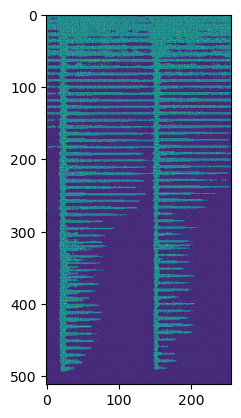

In [27]:
plt.imshow(theta_preds[0])

In [38]:
specs = np.concatenate([x_test_pred[0], data.x_test_theta[0]], axis=-1)

In [39]:
signal = extractor.recover_signal(specs)

In [40]:
Audio(data=signal, rate=22050)

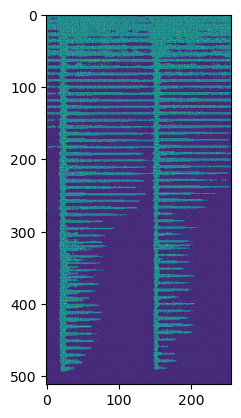

In [31]:
plt.imshow(specs[...,1])

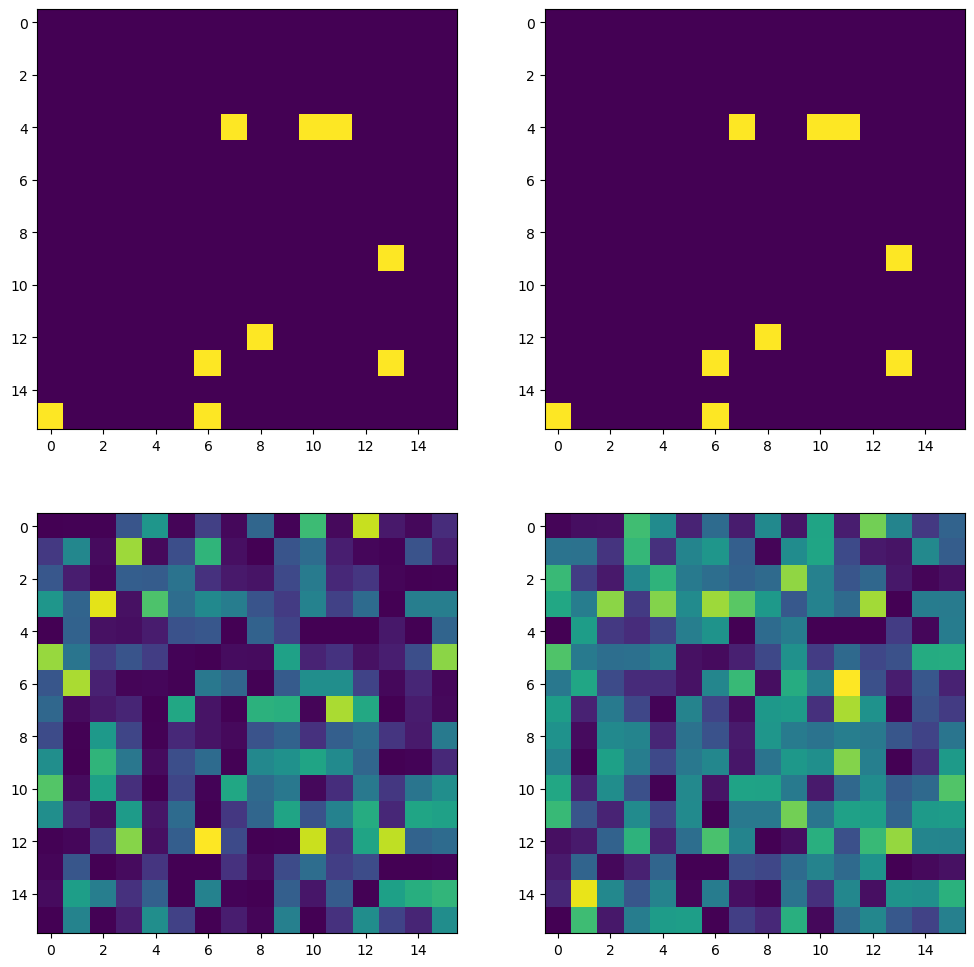

In [321]:
fig, axs = plt.subplots(2, 2, figsize=(12,12))

axs[0,0].imshow(np.where(latent_representations.mean(axis=0).reshape(16,16) == 0, 1, 0))
axs[0,1].imshow(np.where(latent_representations.std(axis=0).reshape(16,16) == 0, 1, 0))
axs[1,0].imshow(latent_representations.mean(axis=0).reshape(16,16))
axs[1,1].imshow(latent_representations.std(axis=0).reshape(16,16))

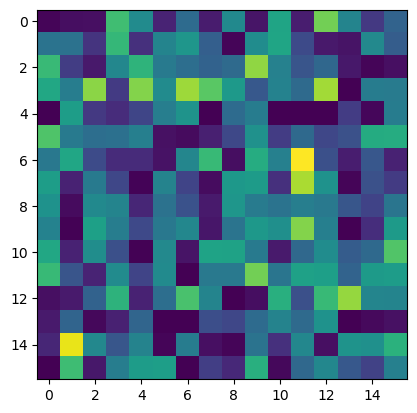

In [204]:
plt.imshow(latent_representations.std(axis=0).reshape(16, 16))

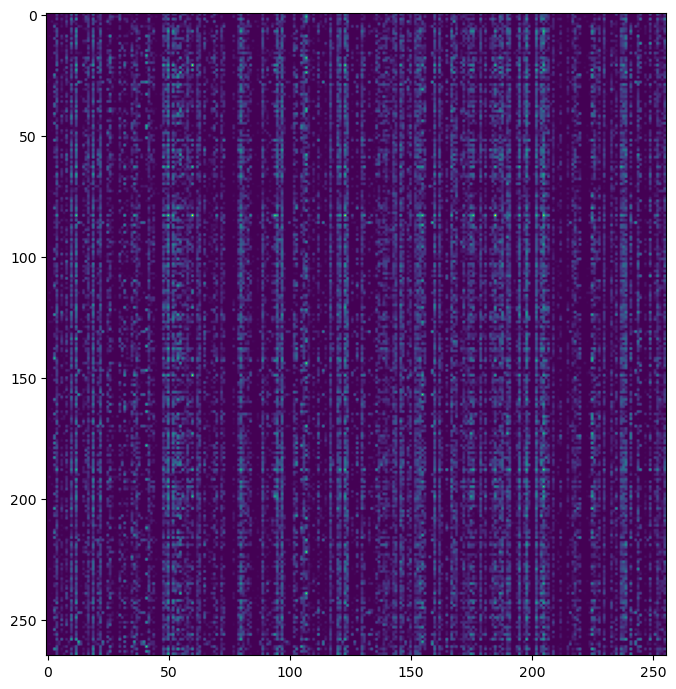

In [198]:
plt.figure(figsize=(8, 16))
plt.imshow(latent_representations)

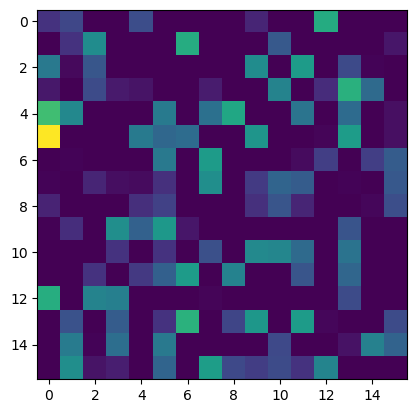

In [177]:
latent_rep_reshape = latent_representations[6].reshape(16, 16)
plt.imshow(latent_rep_reshape)

In [167]:
new_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 256, 128, 32)      320       
                                                                 
 leaky_re_lu_35 (LeakyReLU)  (None, 256, 128, 32)      0         
                                                                 
 conv2d_22 (Conv2D)          (None, 128, 64, 64)       18496     
                                                                 
 leaky_re_lu_36 (LeakyReLU)  (None, 128, 64, 64)       0         
                                                                 
 conv2d_23 (Conv2D)          (None, 64, 32, 128)       73856     
                                                                 
 leaky_re_lu_37 (LeakyReLU)  (None, 64, 32, 128)       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 32, 16, 256)      

In [83]:
def lrelu_bn(inputs):
    lrelu = LeakyReLU()(inputs)
    bn = BatchNormalization()(lrelu)
    return bn  

In [84]:
input_spectrogram = Input(shape=(512, 256, 1))
# Encoder
# strides of 2,2 works like max pooling and downsamples the image
y = Conv2D(32, (3, 3), padding='same',strides =(2,2), name="conv_1")(input_spectrogram)
y = LeakyReLU()(y)
y = Conv2D(64, (3, 3), padding='same',strides =(2,2), name="conv_2")(y)
y = LeakyReLU()(y)
y2 = Conv2D(128, (3, 3), padding='same',strides =(2,2), name="conv_3_skip_1")(y)
y = LeakyReLU()(y2)
y = Conv2D(256, (3, 3), padding='same',strides =(2,2), name="conv_4")(y)
y = LeakyReLU()(y)
y1 = Conv2D(256, (3, 3), padding='same',strides =(2,2), name="conv_5_skip_2")(y)
y = LeakyReLU()(y1)
y = Conv2D(512, (3, 3), padding='same',strides =(2,2), name="conv_6")(y)
y = LeakyReLU()(y)
y = Conv2D(1024, (3, 3), padding='same',strides =(2,2), name="conv_7")(y)
y = LeakyReLU()(y)
dims = y.shape # shape of the final convolutional layer
x = Flatten()(y)
latent = Dense(256,activation='relu', name="bottle_neck")(x) # bottleneck layer to control the information flow

## Decoder

In [85]:
# Decoder

y = Dense(np.prod(dims[1:]), activation='relu')(latent) # accepting the output from the bottleneck layer
y = Reshape((dims[1], dims[2], dims[3]))(y) 
y = Conv2DTranspose(1024, (3,3), padding='same', name="decoder_conv_1")(y)
y = LeakyReLU()(y)
y = Conv2DTranspose(512, (3,3), padding='same',strides=(2,2), name="decoder_conv_2")(y)
y = LeakyReLU()(y)
y = Conv2DTranspose(256, (3,3), padding='same',strides=(2,2), name="decoder_conv_3")(y)
y= Add()([y1, y]) # remove to run model without skip connections
y = lrelu_bn(y)  # remove to run model without skip connections
y = Conv2DTranspose(256, (3,3), padding='same',strides=(2,2), name="decoder_conv_4")(y)
y = LeakyReLU()(y) 
y = Conv2DTranspose(128, (3,3), padding='same',strides=(2,2), name="decoder_conv_5")(y)   
y= Add()([y2, y]) # remove to run model without skip connections
y = lrelu_bn(y) # remove to run model without skip connections
y = Conv2DTranspose(64, (3,3), padding='same',strides=(2,2), name="decoder_conv_6")(y)
y = LeakyReLU()(y)
y = Conv2DTranspose(32, (3,3), padding='same',strides=(2,2), name="decoder_conv_7")(y)
y = LeakyReLU()(y)
output_spectrogram = Conv2DTranspose(1, (3,3), activation='sigmoid', padding='same',strides=(2,2))(y)

In [86]:
skip_model = Model(input_spectrogram, output_spectrogram)

In [87]:
skip_model.load_weights("./256_rho_weights.h5")

2023-06-11 19:18:16.213217: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-11 19:18:16.300591: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-11 19:18:16.606067: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [88]:
preds = skip_model.predict(data.x_test_rho)

/Users/jacksonnelson/miniconda3/envs/tf_metal/lib/python3.8/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-06-11 19:18:32.372397: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [134]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 256)]             0         
                                                                 
 dense_13 (Dense)            (None, 8192)              2105344   
                                                                 
 reshape_9 (Reshape)         (None, 4, 2, 1024)        0         
                                                                 
 decoder_conv_1 (Conv2DTrans  (None, 4, 2, 1024)       9438208   
 pose)                                                           
                                                                 
 leaky_re_lu_103 (LeakyReLU)  (None, 4, 2, 1024)       0         
                                                                 
 decoder_conv_2 (Conv2DTrans  (None, 8, 4, 512)        4719104   
 pose)                                                     

## Theta Decoder

In [8]:
# Decoder
y = Dense(np.prod(dims[1:]), activation='relu')(latent) # accepting the output from the bottleneck layer
y = Reshape((dims[1], dims[2], dims[3]))(y) 
y = Conv2DTranspose(1024, (3,3), padding='same')(y)
y = LeakyReLU()(y)
y = Conv2DTranspose(512, (3,3), padding='same',strides=(2,2))(y)
y = LeakyReLU()(y)
y = Conv2DTranspose(256, (3,3), padding='same',strides=(2,2))(y)
y = LeakyReLU()(y)
y = Conv2DTranspose(256, (3,3), padding='same',strides=(2,2))(y)
y = LeakyReLU()(y) 
y = Conv2DTranspose(128, (3,3), padding='same',strides=(2,2))(y)   
y = LeakyReLU()(y)
y = Conv2DTranspose(64, (3,3), padding='same',strides=(2,2))(y)
y = LeakyReLU()(y)
y = Conv2DTranspose(32, (3,3), padding='same',strides=(2,2))(y)
y = LeakyReLU()(y)
output_spectrogram = Conv2DTranspose(1, (3,3), activation='sigmoid', padding='same',strides=(2,2))(y)

Instructions for updating:
Colocations handled automatically by placer.


## Build Model

In [99]:
skip_ae = Model(input_spectrogram, output_spectrogram, name="skip_ae")

In [100]:
skip_ae.summary()

Model: "skip_ae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 512, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_21 (Conv2D)             (None, 256, 128, 32  320         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu_35 (LeakyReLU)     (None, 256, 128, 32  0           ['conv2d_21[0][0]']              
                                )                                                           

## Compile

In [11]:
skip_ae.compile(
    loss="mse",
    optimizer=Adam(lr=0.0001)
)

## Train

In [20]:
mask_theta_results = skip_ae.fit(
    x = x_train_masks,
    y = y_train_masks,
    validation_data=(x_test_masks, y_test_masks),
    epochs=100,
    batch_size=32
)

Train on 4754 samples, validate on 530 samples
Epoch 1/100


2023-06-10 01:09:33.582044: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-10 01:09:33.654897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-10 01:09:34.035562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4754/4754 [==============================] - ETA: 0s - loss: 0.0404

/Users/jacksonnelson/miniconda3/envs/tf_metal/lib/python3.8/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-06-10 01:11:09.795035: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4754/4754 [==============================] - 100s 21ms/sample - loss: 0.0404 - val_loss: 0.0373
Epoch 2/100
4754/4754 [==============================] - 96s 20ms/sample - loss: 0.0345 - val_loss: 0.0353
Epoch 3/100
4754/4754 [==============================] - 96s 20ms/sample - loss: 0.0332 - val_loss: 0.0335
Epoch 4/100
4754/4754 [==============================] - 96s 20ms/sample - loss: 0.0319 - val_loss: 0.0321
Epoch 5/100
4754/4754 [==============================] - 96s 20ms/sample - loss: 0.0305 - val_loss: 0.0309
Epoch 6/100
4754/4754 [==============================] - 96s 20ms/sample - loss: 0.0295 - val_loss: 0.0296
Epoch 7/100
4754/4754 [==============================] - 96s 20ms/sample - loss: 0.0286 - val_loss: 0.0287
Epoch 8/100
4754/4754 [==============================] - 96s 20ms/sample - loss: 0.0277 - val_loss: 0.0278
Epoch 9/100
4754/4754 [==============================] - 95s 20ms/sample - loss: 0.0268 - val_loss: 0.0270
Epoch 10/100
4754/4754 [========================

In [21]:
skip_ae.save_weights("masked_theta_weights.h5")

2023-06-10 03:51:18.305046: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-10 03:51:18.320563: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-10 03:51:18.330797: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-10 03:51:18.339584: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-10 03:51:18.348485: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-10 03:51:18.358790: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-10 03:51:18.367967: I tensorflow/core/grappler/optimizers/cust

In [12]:
skip_ae.load_weights("./masked_theta_weights.h5")

Metal device set to: Apple M1


2023-06-11 11:25:18.957739: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-11 11:25:18.957860: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-06-11 11:25:18.974945: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-06-11 11:25:18.975155: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-11 11:25:18.997755: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-11 11:25:19.178026: I tensorflow/core/grappler/o

In [22]:
pd.DataFrame(mask_theta_results.history).to_csv("256_mask_theta_history.csv")

In [15]:
test_pred_mask = skip_ae.predict(x_test_masks)

/Users/jacksonnelson/miniconda3/envs/tf_metal/lib/python3.8/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-06-11 11:28:58.412187: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [18]:

signal = extractor.recover_signal(np.concatenate([data.y_test_rho[0], test_pred_mask[0]], axis=2))
original_signal = extractor.recover_signal(data.y_test[0])

In [52]:
def display_audio(signal, title=None):
    
    if title:
        print(f"{title.title()}")
    
    display(Audio(data=signal, rate=22050))

In [62]:
def get_masked_theta(rho, theta):
    
    mask = np.where(rho < rho.mean(), 0, 1)
    
    return theta * mask

In [63]:
def stack_spectrograms(channel_1, channel_2):
    
    assert channel_1.shape == channel_2.shape, f"Arrays must have the same shape,\
    got got shapes: {channel_1.shape}, {channel_2.shape}"
    
    if len(channel_1.shape) == 2:
        return np.stack([channel_1, channel_2], axis=-1)
    else:
        return np.concatenate([channel_1, channel_2], axis=-1)

# Sample Simple Binary Phase Masks

In [66]:
def simple_theta_masking(dataset, idx=None):
    
    if not idx:
        idx = np.random.randint(low=0, high=len(dataset.y_test))
    
    print(f"Sample {idx} from the test dataset. \n")
    rho = dataset.y_test_rho[idx]
    theta = dataset.y_test_theta[idx]
    masked_theta = get_masked_theta(rho, theta)
    masked_spec = stack_spectrograms(rho, masked_theta)
    
    masked_signal = extractor.recover_signal(masked_spec)
    original_signal = extractor.recover_signal(data.y_test[idx])
    
    display_audio(masked_signal, "masked signal")
    display_audio(original_signal, "original signal")

In [68]:
simple_theta_masking(data)

Sample 112 from the test dataset. 

Masked Signal


Original Signal


# Sample Predicted Phases from Masks

In [28]:
i = np.random.randint(low = 0, high = len(data.x_test))
print(i)

pred_signal = extractor.recover_signal(np.concatenate([data.y_test_rho[i], test_pred_mask[i]], axis=2))
noisy_phase_signal = extractor.recover_signal(np.concatenate([data.y_test_rho[i], data.x_test_theta[i]], axis=2))
original_signal = extractor.recover_signal(data.y_test[i])

display(Audio(data=pred_signal, rate=22050))
display(Audio(data=noisy_phase_signal, rate=22050))
display(Audio(data=original_signal, rate=22050))

223


# Notes

* 123 demonstrates improved perceived pitch
* 55 demonstrates worse audio quality